# Word2Vec Model Trainer

In [1]:
import gensim
import codecs
import json
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

class Corpus_Iterator(object):
    def __init__(self,filename):
        self.filename = filename
        ind=0
        for line in codecs.open(filename,'r',encoding='utf8'):
            ind+=1
        self.size=ind
        
    def __iter__(self):
        ind=0
        for line in codecs.open(self.filename,'r',encoding='utf8'):
            try:
                record = json.loads(line)
            except:
                print(line +' '*10+str(ind))
            title = record['title']
            abstract_sents = record['abstract']
            ind+=1
            if ind%1000==0:
                percent = int(100*float(ind)/self.size)
                sys.stdout.write('\r[{0}] {1}% {2}'.format('#'*(percent/10), percent, ind))
                sys.stdout.flush()
            yield title.split()
            for sent in abstract_sents:
                yield sent.split()
        print()
    

class Rhubarb_Corpus_Iterator(object):
    def __init__(self,filename):
        self.filename = filename
        ind=0
        for line in codecs.open(filename,'r',encoding='utf8'):
            ind+=1
        self.size=ind
        
    def __iter__(self):
        ind=0
        for line in codecs.open(self.filename,'r',encoding='utf8'):
            if ind%1000==0:
                percent = int(100*float(ind)/self.size)
                sys.stdout.write('\r[{0}] {1}% {2}'.format('#'*(percent/10), percent, ind))
                sys.stdout.flush()
            ind+=1
            yield line.split()
        print()

corpus_file = 'exp2.json'
rhubarb_file = 'corpnatural.txt'



/Users/lewisp123/miniconda2/envs/Fruitbowl/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
corpus_file = 'exp2.json'
corp = Corpus_Iterator(corpus_file)
model = gensim.models.Word2Vec(corp,min_count=1,size=50)
model.save('ConstrainedRaspberryEngine')


[#########] 99% 449000()
[#########] 99% 449000()


In [11]:
model = gensim.models.Word2Vec.load('RaspberryEngine')

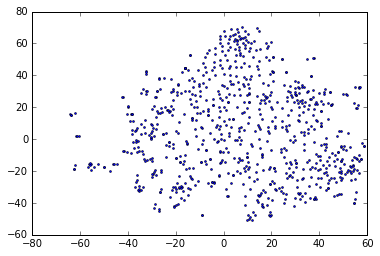

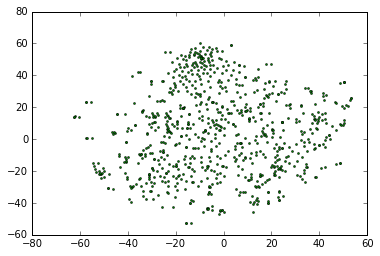

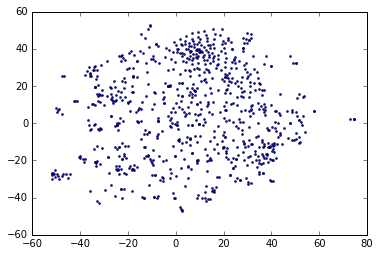

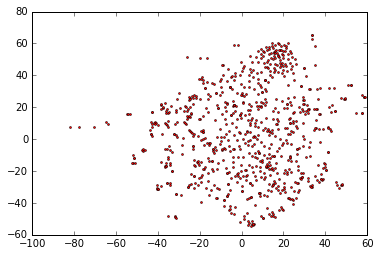

In [113]:
%matplotlib inline
t = TSNE(perplexity= 10.0, early_exaggeration=40.0,init='pca')
X_t = t.fit_transform(newstore)
plt.plot(X_t[:,0],X_t[:,1],'bo',markersize=2)
plt.show()
t = TSNE(perplexity= 10.0, early_exaggeration=30.0,init='pca')
X_t = t.fit_transform(newstore)
plt.plot(X_t[:,0],X_t[:,1],'go',markersize=2)
plt.show()
t = TSNE(perplexity= 10.0, early_exaggeration=20.0,init='pca')
X_t = t.fit_transform(newstore)
plt.plot(X_t[:,0],X_t[:,1],'bo',markersize=2)
plt.show()
t = TSNE(perplexity= 10.0, early_exaggeration=10.0,init='pca')
X_t = t.fit_transform(newstore)
plt.plot(X_t[:,0],X_t[:,1],'ro',markersize=2)#plt.show()
plt.show()

In [6]:
def VisualiseCluster(model,corpus_file,agg_fun, sample_size, tsne_params,cluster_no):
    print('Calculating Corpus size')
    corpus_size=490000
    print('corpus size: '+str(corpus_size))
    randoms = [random.randint(0,corpus_size) for i in range(sample_size)]
    sample=[]
    ind=0
    print('sampling '+str(sample_size)+' random records')
    for line in codecs.open(corpus_file,'r',encoding='utf8'):
        if ind in randoms:
            record = json.loads(line)
            sample.append(record)
        ind+=1
        if ind%1000==0:
            percent = int(100*float(ind)/corpus_size)
            sys.stdout.write('\r[{0}] {1}% {2}'.format('#'*(percent/10), percent, ind))
            sys.stdout.flush()
    sample_size=len(sample) #re-adjust sample size in case of duplicates
    dimensionality=50
    print('\nGenerating article vectors')
    article_vecs = np.zeros((sample_size,dimensionality))
    ind = 0
    for s in sample:
        article_vecs[ind,:]=agg_fun(s,model,dimensionality)
        ind+=1
        if ind%100==0:
            percent = int(100*float(ind)/sample_size)
            sys.stdout.write('\r[{0}] {1}% {2}'.format('#'*(percent/10), percent, ind))
            sys.stdout.flush()
    print('\nPerforming Dimensional Reduction')
    sys.stdout.flush()
    t = TSNE(init='pca',perplexity= 10.0, early_exaggeration=10.0)
    reduced_article_vecs = t.fit_transform(article_vecs)
    print('Generating cluster centres')
    kmeans = KMeans(n_clusters=cluster_no,init='k-means++',max_iter=50000,verbose=0,tol=0.00000000001)
    cluster_centres =kmeans.fit(reduced_article_vecs).cluster_centers_
    print('Calculating cluster distances')
    distances = np.zeros([sample_size,cluster_no])
    ind=0
    for centroid in cluster_centres:
        distances[:,ind]=np.sum((reduced_article_vecs-centroid)**2,axis=1)**.5
        ind+=1
    cluster=np.argmin(distances,axis=1)
    print('plotting results')
    colors=iter(plt.cm.rainbow(np.linspace(0,1,cluster_no)))
    for i in range(cluster_no):
        clus = reduced_article_vecs[np.where(cluster==i)[0]]
        color = next(colors)
        plt.plot(clus[:,0],clus[:,1],'.',c=color, markersize=3)
        plt.plot(cluster_centres[i,0],cluster_centres[i,1],'o',c=color)
    plt.show()    

In [7]:
def rhubarb_agg(s,model,dimensionality):
    mod = 0
    acc=np.zeros(dimensionality)
    for w in s.split():
        mod+=1
        acc+=model[w]
    return acc/mod

def rasbpberry_agg(s,model,dimensionality):
    mod = 0
    acc=np.zeros(dimensionality)
    for w in s['title'].split():
        mod+=1
        acc+=model[w]
    for se in s['abstract']:
        for w in se.split():
            acc+=model[w]
            mod+=1
    return acc/mod

def apple_agg(s,model,dimensionality):
    acc=np.zeros(dimensionality)
    record = filter(lambda x: x != [], s[0])
    weights = s[1]
    divisor = 0
    sent_no = len(record)
    for i in range(sent_no):
        sent = record[i]
        weight= weights[i]
        for j in range(len(sent)):
            acc+=weight[j]*(model[sent[j]])
            divisor+=weight[j]
    return acc/divisor

def apple_agg_simple(s,model,dimensionality):
    acc=np.zeros(dimensionality)
    record = filter(lambda x: x != [], s[0])
    divisor = 0
    sent_no = len(record)
    for i in range(sent_no):
        sent = record[i]
        for j in range(len(sent)):
            acc+=(model[sent[j]])
            divisor+=1
    return acc/divisor            

In [8]:
corpus_file = 'Testexp3.json'
#model = gensim.models.Word2Vec.load('RaspberryEngine')
VisualiseCluster(model,corpus_file,apple_agg, 2000, _,1)

Calculating Corpus size
corpus size: 490000
sampling 2000 random records
[#########] 91% 449000
Generating article vectors
[#########] 97% 1800
Performing Dimensional Reduction
Generating cluster centres
Calculating cluster distances
plotting results


In [ ]:
rhubarb_file='hardernatural.txt'
#corp = Rhubarb_Corpus_Iterator(rhubarb_file)
#model = gensim.models.Word2Vec(corp,min_count=1,size=100)
#model.save('RhubarbEngine')
VisualiseRhubarbCluster(model,rhubarb_file,2000,_,50)

In [35]:
a =[1,2,3,1]
a.remove(1)

In [45]:
len(j[0])

3

In [53]:
a.remove([])

In [54]:
a

[[u'found',
  u'amorph',
  u'sulfur',
  u'solid',
  u'state',
  u'polymer',
  u'irradi',
  u'light',
  u'order',
  u'demonstr',
  u'photopolymer',
  u'sulfur',
  u'absorpt',
  u'spectra',
  u'thermal',
  u'properti',
  u'solubib',
  u'sulfur',
  u'measur'],
 [u'prove', u'find', u'true']]